In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display, Markdown

# Pembangkitan Data

In [2]:
np.random.seed(17)
populasi = []

# Simulasi populasi pada Provinsi
for kab in range(1, 16):
    n_kec = int(np.round(np.random.uniform(3, 6)))
    for kec in range(1, n_kec + 1):
        n_desa = int(np.round(np.random.uniform(5, 9)))
        for desa in range(1, n_desa + 1):
            desa_kel = 1 if np.random.uniform() < 0.6 else 2
            if desa_kel == 1:
                populasi_penduduk = int(np.round(np.random.uniform(30, 50)))
            else:
                populasi_penduduk = int(np.round(np.random.uniform(45, 88)))
            populasi.append({
                'kab': kab,
                'kec': kec,
                'desa': desa,
                'desa_kel': desa_kel,
                'populasi_penduduk': populasi_penduduk})
populasi_df = pd.DataFrame(populasi)

# Simulasi individu dan pendapatan
individu_rows = []
for _, row in populasi_df.iterrows():
    n = row['populasi_penduduk']
    desa_kel = row['desa_kel']
    if desa_kel == 1:
        # Desa: pendapatan ~ Gamma disesuaikan ke range 1 juta - 3 juta (dalam jt)
        pendapatan_raw = np.random.gamma(shape=2.0, scale=1.0, size=n)
        pendapatan_scaled = np.interp(pendapatan_raw, (pendapatan_raw.min(), pendapatan_raw.max()), [1, 3]).round(2)
    else:
        # Kota: pendapatan ~ Gamma disesuaikan ke range 4 juta - 8 juta (dalam jt)
        pendapatan_raw = np.random.gamma(shape=2.0, scale=2.0, size=n)
        pendapatan_scaled = np.interp(pendapatan_raw, (pendapatan_raw.min(), pendapatan_raw.max()), [4, 8]).round(2)
    individu_rows.extend([{
        'kab': row['kab'],
        'kec': row['kec'],
        'desa': row['desa'],
        'desa_kel': desa_kel,
        'individu': 1,
        'pendapatan': p} for p in pendapatan_scaled])
individu_df = pd.DataFrame(individu_rows)
individu_df

,kab,kec,desa,desa_kel,individu,pendapatan
0,1,1,1,1,1,1.86
1,1,1,1,1,1,1.76
2,1,1,1,1,1,1.01
3,1,1,1,1,1,1.86
4,1,1,1,1,1,1.20
...,...,...,...,...,...,...
24856,15,5,7,1,1,2.87
24857,15,5,7,1,1,1.63
24858,15,5,7,1,1,1.44
24859,15,5,7,1,1,1.00


In [3]:
# Statistika Deskriptif
struktur_df = populasi_df.groupby('kab').agg(
    jumlah_kec=('kec', 'nunique'),
    jumlah_desa=('desa', 'count')).reset_index()

pop_individu_df = individu_df.groupby('kab').agg(
    populasi_penduduk=('individu', 'sum'),
    total_pendapatan=('pendapatan', 'sum'),
    rataan_pendapatan=('pendapatan', 'mean')).reset_index()
summary = pd.merge(struktur_df, pop_individu_df, on='kab')

total_row = pd.DataFrame({
    'kab': ['Total'],
    'jumlah_kec': [summary['jumlah_kec'].sum()],
    'jumlah_desa': [summary['jumlah_desa'].sum()],
    'populasi_penduduk': [summary['populasi_penduduk'].sum()],
    'total_pendapatan': [summary['total_pendapatan'].sum()],
    'rataan_pendapatan': [summary['total_pendapatan'].sum() / summary['populasi_penduduk'].sum()]})
total_kab = pd.concat([summary, total_row], ignore_index=True)
total_kab['total_pendapatan'] = total_kab['total_pendapatan'].round(2)
total_kab['rataan_pendapatan'] = total_kab['rataan_pendapatan'].round(2)
total_kab

,kab,jumlah_kec,jumlah_desa,populasi_penduduk,total_pendapatan,rataan_pendapatan
0,1,4,30,1468,5347.28,3.64
1,2,3,20,1118,4251.10,3.80
2,3,6,43,2151,6927.06,3.22
3,4,6,41,2264,9013.29,3.98
4,5,4,25,1380,5854.11,4.24
5,6,5,34,1589,4578.51,2.88
6,7,4,28,1329,3931.07,2.96
7,8,5,38,1755,5247.07,2.99
8,9,5,37,1817,5805.58,3.20
9,10,6,41,2325,8934.49,3.84


In [4]:
len(individu_df)

24861

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_24644\3788840706.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title='Strata', fontsize=11, title_fontsize=12)


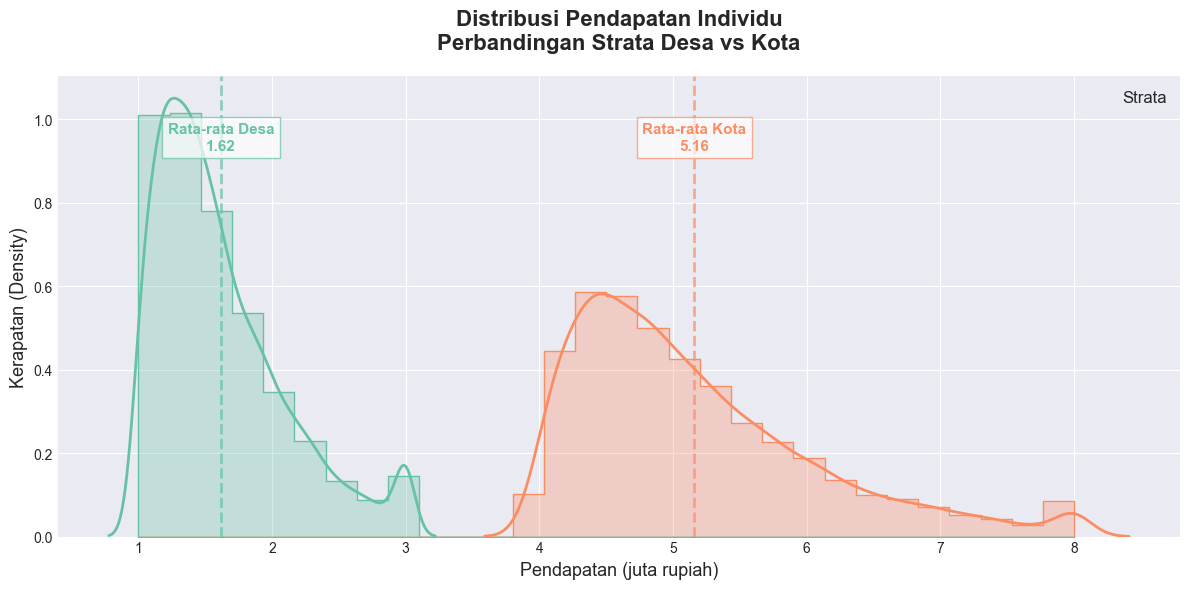

In [5]:
plt.style.use('seaborn-v0_8-darkgrid')
individu_df_plot = individu_df.copy()
individu_df_plot['Strata'] = individu_df_plot['desa_kel'].map({1: 'Desa', 2: 'Kota'})

fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(
    data=individu_df_plot, x='pendapatan', hue='Strata',
    element='step', stat='density', common_norm=False,
    bins=30, palette='Set2', alpha=0.3, ax=ax)

sns.kdeplot(
    data=individu_df_plot, x='pendapatan', hue='Strata',
    common_norm=False, palette='Set2', linewidth=2, ax=ax)

for strata, color in zip(['Desa', 'Kota'], sns.color_palette('Set2')):
    mean_val = individu_df_plot[individu_df_plot['Strata'] == strata]['pendapatan'].mean()
    ax.axvline(mean_val, color=color, linestyle='--', linewidth=2, alpha=0.7)
    ax.text(mean_val, ax.get_ylim()[1]*0.9, f'Rata-rata {strata}\n{mean_val:.2f}', 
            color=color, fontsize=11, ha='center', va='top', fontweight='bold', bbox=dict(facecolor='white', alpha=0.7, edgecolor=color))

ax.set_title("Distribusi Pendapatan Individu\nPerbandingan Strata Desa vs Kota", fontsize=16, weight='bold', pad=20)
ax.set_xlabel("Pendapatan (juta rupiah)", fontsize=13)
ax.set_ylabel("Kerapatan (Density)", fontsize=13)
ax.legend(title='Strata', fontsize=11, title_fontsize=12)
plt.tight_layout()
plt.show()


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_24644\3617915765.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


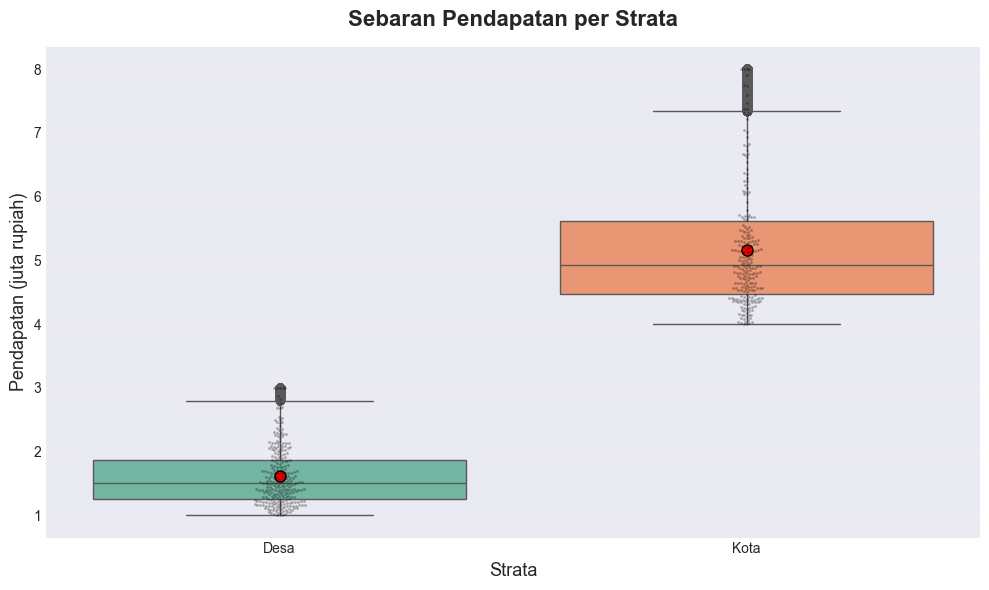

In [6]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=individu_df_plot, x='Strata', y='pendapatan', palette='Set2', showmeans=True,
    meanprops={"marker":"o", "markerfacecolor":"red", "markeredgecolor":"black", "markersize":"8"})
sns.swarmplot(
    data=individu_df_plot.sample(500, random_state=1), x='Strata', y='pendapatan', color='k', alpha=0.3, size=2)
plt.title("Sebaran Pendapatan per Strata", fontsize=16, weight='bold', pad=15)
plt.xlabel("Strata", fontsize=13)
plt.ylabel("Pendapatan (juta rupiah)", fontsize=13)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


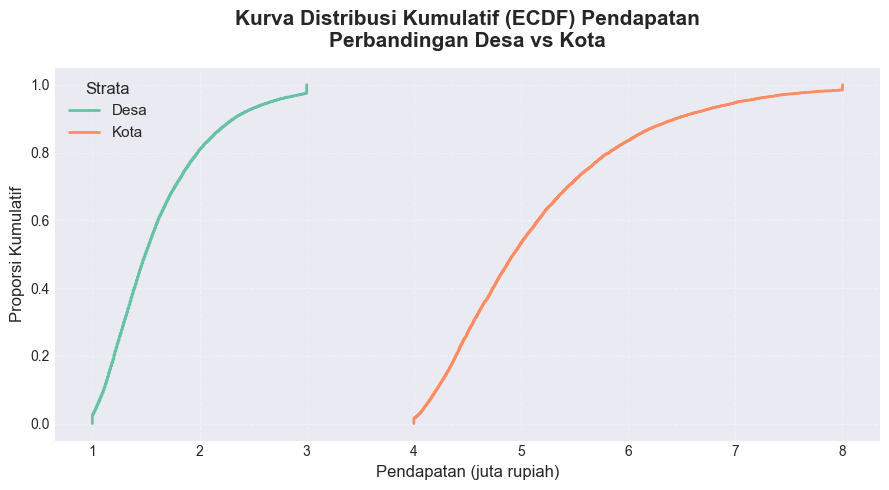

> **Catatan:**
> Kurva ECDF menunjukkan bahwa pendapatan di strata Kota secara konsisten lebih tinggi dibandingkan Desa. Mayoritas penduduk Desa memiliki pendapatan di bawah 3 juta, sedangkan di Kota, pendapatan lebih tersebar dan banyak yang di atas 4 juta. Visualisasi ini memudahkan kita melihat ketimpangan distribusi pendapatan antara Desa dan Kota secara sederhana.

In [7]:
plt.figure(figsize=(9, 5))
colors = {1: '#66c2a5', 2: '#fc8d62'}
labels = {1: 'Desa', 2: 'Kota'}

for label, df_group in individu_df.groupby('desa_kel'):
    sorted_vals = np.sort(df_group['pendapatan'])
    ecdf = np.arange(1, len(sorted_vals)+1) / len(sorted_vals)
    plt.plot(sorted_vals, ecdf, label=labels[label], color=colors[label], linewidth=2)

plt.title("Kurva Distribusi Kumulatif (ECDF) Pendapatan\nPerbandingan Desa vs Kota", fontsize=15, weight='bold', pad=15)
plt.xlabel("Pendapatan (juta rupiah)", fontsize=12)
plt.ylabel("Proporsi Kumulatif", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(title='Strata', fontsize=11, title_fontsize=12)
plt.tight_layout()
plt.show()

display(Markdown(
"> **Catatan:**\n"
"> Kurva ECDF menunjukkan bahwa pendapatan di strata Kota secara konsisten lebih tinggi dibandingkan Desa. "
"Mayoritas penduduk Desa memiliki pendapatan di bawah 3 juta, sedangkan di Kota, pendapatan lebih tersebar dan banyak yang di atas 4 juta. "
"Visualisasi ini memudahkan kita melihat ketimpangan distribusi pendapatan antara Desa dan Kota secara sederhana."
))


# Penarikan Contoh Acak Sederhana

## Definisi Fungsi

In [8]:
def srs_combined_table_repeat(data_individu, ns, max_r):
    total_populasi = data_individu['individu'].sum() 
    rataan_pendapatan = data_individu['pendapatan'].mean()
    total_pendapatan = data_individu['pendapatan'].sum()

    total_pendapatan_duga = []
    rataan_pendapatan_duga = []
    repeat_values = []
    jumlah_sampel_list = []

    for n_value in ns:
        for r in range(1, max_r + 1):
            total_y_bar = []
            mean_y_bar = []

            for _ in range(r):
                if n_value <= len(data_individu):
                    sampel = data_individu.sample(n=n_value, replace=False)
                else:
                    print(f"Ukuran sampel {n_value} melebihi populasi. Dilewati.")
                    continue

                # Penduga total pendapatan
                mean_sample = sampel['pendapatan'].mean()
                total_y = mean_sample * total_populasi
                total_y_bar.append(total_y)

                # Penduga rata-rata pendapatan
                mean_y_bar.append(mean_sample)

            total_pendapatan_duga.append(np.mean(total_y_bar))
            rataan_pendapatan_duga.append(np.mean(mean_y_bar))
            repeat_values.append(r)
            jumlah_sampel_list.append(n_value)

    output_table = pd.DataFrame({
        'Jumlah_Sampel': jumlah_sampel_list,
        'Repeat': repeat_values,
        'Total_Penduduk': [total_populasi] * len(jumlah_sampel_list),
        'Total_Pendapatan_Asli': [total_pendapatan] * len(jumlah_sampel_list),
        'Rataan_Pendapatan_Asli': [rataan_pendapatan] * len(jumlah_sampel_list),
        'Total_Pendapatan_Duga': total_pendapatan_duga,
        'Rataan_Pendapatan_Duga': rataan_pendapatan_duga})
    return output_table

In [9]:
penduga_srs = srs_combined_table_repeat(
    data_individu=individu_df, 
    ns=[2000, 8000, 16000], 
    max_r=20)
penduga_srs.round(2)

,Jumlah_Sampel,Repeat,Total_Penduduk,Total_Pendapatan_Asli,Rataan_Pendapatan_Asli,Total_Pendapatan_Duga,Rataan_Pendapatan_Duga
0,2000,1,24861,84405.27,3.4,82037.94,3.30
1,2000,2,24861,84405.27,3.4,85270.12,3.43
2,2000,3,24861,84405.27,3.4,84945.77,3.42
3,2000,4,24861,84405.27,3.4,85539.46,3.44
4,2000,5,24861,84405.27,3.4,83412.16,3.36
5,2000,6,24861,84405.27,3.4,84399.55,3.39
6,2000,7,24861,84405.27,3.4,84555.19,3.40
7,2000,8,24861,84405.27,3.4,84121.82,3.38
8,2000,9,24861,84405.27,3.4,84665.14,3.41
9,2000,10,24861,84405.27,3.4,84742.07,3.41


## Metriks Evaluasi PCAS

In [10]:
def calculate_metrics(result_df):
    metrics_list = []

    for n_value in sorted(result_df['Jumlah_Sampel'].unique()):
        subset = result_df[result_df['Jumlah_Sampel'] == n_value]

        Y_true_total = subset['Total_Pendapatan_Asli'].values[0]
        Y_true_mean = subset['Rataan_Pendapatan_Asli'].values[0]

        Y_hat_total = subset['Total_Pendapatan_Duga'].values
        Y_hat_mean = subset['Rataan_Pendapatan_Duga'].values

        # Average Absolute Relative Bias (ARB)
        arb_total = np.mean(np.abs(Y_hat_total / Y_true_total - 1))
        arb_mean = np.mean(np.abs(Y_hat_mean / Y_true_mean - 1))

        # Average Absolute Relative Error (ARE)
        are_total = arb_total
        are_mean = arb_mean

        # Relative Root Mean Square Error (RRMSE)
        mse_total = np.mean((Y_hat_total - Y_true_total) ** 2)
        rrmse_total = np.sqrt(mse_total) / Y_true_total
        mse_mean = np.mean((Y_hat_mean - Y_true_mean) ** 2)
        rrmse_mean = np.sqrt(mse_mean) / Y_true_mean

        # Mean Absolute Error (MAE) - selisih absolut rata-rata (dalam satuan asli)
        mae_total = np.mean(np.abs(Y_hat_total - Y_true_total))
        mae_mean = np.mean(np.abs(Y_hat_mean - Y_true_mean))

        metrics_list.append({
            'Jumlah_Sampel': n_value,
            'ARB_Total_Pendapatan': round(arb_total, 4),
            'ARE_Total_Pendapatan': round(are_total, 4),
            'RRMSE_Total_Pendapatan': round(rrmse_total, 4),
            'MAE_Total_Pendapatan': round(mae_total, 2),

            'ARB_Rataan_Pendapatan': round(arb_mean, 4),
            'ARE_Rataan_Pendapatan': round(are_mean, 4),
            'RRMSE_Rataan_Pendapatan': round(rrmse_mean, 4),
            'MAE_Rataan_Pendapatan': round(mae_mean, 2)})

    return pd.DataFrame(metrics_list)


In [11]:
metrics_df = calculate_metrics(penduga_srs)
metrics_df

,Jumlah_Sampel,ARB_Total_Pendapatan,ARE_Total_Pendapatan,RRMSE_Total_Pendapatan,MAE_Total_Pendapatan,ARB_Rataan_Pendapatan,ARE_Rataan_Pendapatan,RRMSE_Rataan_Pendapatan,MAE_Rataan_Pendapatan
0,2000,0.0055,0.0055,0.0083,460.51,0.0055,0.0055,0.0083,0.02
1,8000,0.0011,0.0011,0.0015,90.20,0.0011,0.0011,0.0015,0.00
2,16000,0.0007,0.0007,0.0008,56.97,0.0007,0.0007,0.0008,0.00


# Penarikan Contoh Gerombol 1 Tahap

## Definisi Fungsi

In [12]:
def oss_combined_table(data, n_clusters_list, max_r):
    total_populasi = data['individu'].sum()
    rataan_pendapatan = data['pendapatan'].mean()
    total_pendapatan = data['pendapatan'].sum()

    total_pendapatan_duga = []
    rataan_pendapatan_duga = []
    repeat_values = []
    jumlah_cluster_list = []

    unique_clusters = data['kab'].unique()
    total_clusters = len(unique_clusters)

    for n_clusters in n_clusters_list:
        for r in range(1, max_r + 1):
            total_y_bar = []
            mean_y_bar = []

            for _ in range(r):
                # Sampling cluster (kabupaten) tanpa pengembalian
                selected_clusters = np.random.choice(unique_clusters, size=n_clusters, replace=False)
                sampel = data[data['kab'].isin(selected_clusters)]

                # Estimasi total pendapatan: total sampel * (total cluster / cluster sampel)
                total_y = sampel['pendapatan'].sum() * (total_clusters / n_clusters)
                total_y_bar.append(total_y)

                # Estimasi rata-rata pendapatan dari sampel
                mean_y = sampel['pendapatan'].mean()
                mean_y_bar.append(mean_y)

            total_pendapatan_duga.append(np.mean(total_y_bar))
            rataan_pendapatan_duga.append(np.mean(mean_y_bar))
            repeat_values.append(r)
            jumlah_cluster_list.append(n_clusters)

    output_table = pd.DataFrame({
        'Jumlah_Cluster': jumlah_cluster_list,
        'Repeat': repeat_values,
        'Total_Penduduk': [total_populasi] * len(jumlah_cluster_list),
        'Total_Pendapatan_Asli': [total_pendapatan] * len(jumlah_cluster_list),
        'Rataan_Pendapatan_Asli': [rataan_pendapatan] * len(jumlah_cluster_list),
        'Total_Pendapatan_Duga': total_pendapatan_duga,
        'Rataan_Pendapatan_Duga': rataan_pendapatan_duga
    })

    return output_table


In [33]:
result_oss = oss_combined_table(individu_df, n_clusters_list=[6, 9, 12], max_r=20)
result_oss.round(2)

,Jumlah_Cluster,Repeat,Total_Penduduk,Total_Pendapatan_Asli,Rataan_Pendapatan_Asli,Total_Pendapatan_Duga,Rataan_Pendapatan_Duga
0,6,1,24861,84405.27,3.4,88055.95,3.52
1,6,2,24861,84405.27,3.4,78893.62,3.28
2,6,3,24861,84405.27,3.4,85849.48,3.47
3,6,4,24861,84405.27,3.4,78655.41,3.22
4,6,5,24861,84405.27,3.4,86636.56,3.45
5,6,6,24861,84405.27,3.4,82253.54,3.38
6,6,7,24861,84405.27,3.4,82915.05,3.40
7,6,8,24861,84405.27,3.4,86766.61,3.44
8,6,9,24861,84405.27,3.4,85186.25,3.37
9,6,10,24861,84405.27,3.4,83606.67,3.38


## Metriks Evaluasi

In [34]:
def calculate_metrics_pcag1(result_df, jumlah_sampel_col='Jumlah_Sampel'):
    metrics_list = []

    for n_value in sorted(result_df[jumlah_sampel_col].unique()):
        subset = result_df[result_df[jumlah_sampel_col] == n_value]

        Y_true_total = subset['Total_Pendapatan_Asli'].values[0]
        Y_true_mean = subset['Rataan_Pendapatan_Asli'].values[0]

        Y_hat_total = subset['Total_Pendapatan_Duga'].values
        Y_hat_mean = subset['Rataan_Pendapatan_Duga'].values

        arb_total = np.mean(np.abs(Y_hat_total / Y_true_total - 1))
        arb_mean = np.mean(np.abs(Y_hat_mean / Y_true_mean - 1))

        are_total = arb_total
        are_mean = arb_mean

        mse_total = np.mean((Y_hat_total - Y_true_total) ** 2)
        rrmse_total = np.sqrt(mse_total) / Y_true_total

        mse_mean = np.mean((Y_hat_mean - Y_true_mean) ** 2)
        rrmse_mean = np.sqrt(mse_mean) / Y_true_mean

        mae_total = np.mean(np.abs(Y_hat_total - Y_true_total))
        mae_mean = np.mean(np.abs(Y_hat_mean - Y_true_mean))

        metrics_list.append({
            jumlah_sampel_col: n_value,
            'ARB_Total_Pendapatan': round(arb_total, 4),
            'ARE_Total_Pendapatan': round(are_total, 4),
            'RRMSE_Total_Pendapatan': round(rrmse_total, 4),
            'MAE_Total_Pendapatan': round(mae_total, 2),

            'ARB_Rataan_Pendapatan': round(arb_mean, 4),
            'ARE_Rataan_Pendapatan': round(are_mean, 4),
            'RRMSE_Rataan_Pendapatan': round(rrmse_mean, 4),
            'MAE_Rataan_Pendapatan': round(mae_mean, 2)
        })

    return pd.DataFrame(metrics_list)


In [35]:
metrics_df_pcag1 = calculate_metrics_pcag1(result_oss, jumlah_sampel_col='Jumlah_Cluster')
metrics_df_pcag1

,Jumlah_Cluster,ARB_Total_Pendapatan,ARE_Total_Pendapatan,RRMSE_Total_Pendapatan,MAE_Total_Pendapatan,ARB_Rataan_Pendapatan,ARE_Rataan_Pendapatan,RRMSE_Rataan_Pendapatan,MAE_Rataan_Pendapatan
0,6,0.0290,0.0290,0.0355,2451.44,0.0129,0.0129,0.0189,0.04
1,9,0.0224,0.0224,0.0330,1894.58,0.0094,0.0094,0.0149,0.03
2,12,0.0136,0.0136,0.0172,1150.82,0.0063,0.0063,0.0088,0.02


In [ ]:
# Jika ingin Gerombol Optimal
from itertools import combinations

unique_clusters = individu_df['kab'].unique()
best_error = float('inf')
best_combo = None

for combo in combinations(unique_clusters, 3):
    sampel = individu_df[individu_df['kab'].isin(combo)]
    total_y = sampel['pendapatan'].sum() * (len(unique_clusters) / 3)
    error = abs(total_y - individu_df['pendapatan'].sum())
    if error < best_error:
        best_error = error
        best_combo = combo

print("Kombinasi 3 cluster optimal:", best_combo)
print("Error:", best_error)

Kombinasi 3 cluster optimal: (6, 10, 14)
Error: 18.629999999990105


# Penarikan Contoh Gerombol 2 Tahap

## Definisi Fungsi

In [44]:
import numpy as np
import pandas as pd

def tss_combined_table(data, n_clusters_list, n_kec_list, max_r):
    total_populasi = data['individu'].sum()
    rataan_pendapatan = data['pendapatan'].mean()
    total_pendapatan = data['pendapatan'].sum()
    
    unique_clusters = data['kab'].unique()
    N = len(unique_clusters)
    
    output_size = len(n_clusters_list) * len(n_kec_list) * max_r
    
    total_pendapatan_duga_tss = np.zeros(output_size)
    rataan_pendapatan_duga_tss = np.zeros(output_size)
    
    row_index = 0
    
    for r in range(max_r):
        for n_clusters in n_clusters_list:
            for n_kec in n_kec_list:
                total_pendapatan_per_cluster = []
                mean_pendapatan_per_cluster = []
                
                # Tahap 1: Pilih cluster (kabupaten)
                if n_clusters <= N:
                    selected_clusters = np.random.choice(unique_clusters, size=n_clusters, replace=False)
                else:
                    raise ValueError("Jumlah cluster yang diambil melebihi total cluster yang ada.")
                
                for cluster in selected_clusters:
                    # Tahap 2: Pilih kecamatan dalam cluster tersebut
                    kecamatan_in_cluster = data.loc[data['kab'] == cluster, 'kec'].unique()
                    if len(kecamatan_in_cluster) >= n_kec:
                        selected_kec = np.random.choice(kecamatan_in_cluster, size=n_kec, replace=False)
                    else:
                        selected_kec = np.random.choice(kecamatan_in_cluster, size=n_kec, replace=True)
                    
                    sampel = data[(data['kab'] == cluster) & (data['kec'].isin(selected_kec))]
                    
                    total_pendapatan_cluster = sampel['pendapatan'].sum()
                    mean_pendapatan_cluster = sampel['pendapatan'].mean()
                    
                    total_pendapatan_per_cluster.append(total_pendapatan_cluster)
                    mean_pendapatan_per_cluster.append(mean_pendapatan_cluster)
                
                # Estimasi total pendapatan populasi dari sampling dua tahap
                total_estimate = (N / n_clusters) * np.sum(total_pendapatan_per_cluster)
                # Estimasi rata-rata pendapatan populasi dari sampling dua tahap
                mean_estimate = np.mean(mean_pendapatan_per_cluster)
                
                total_pendapatan_duga_tss[row_index] = total_estimate
                rataan_pendapatan_duga_tss[row_index] = mean_estimate
                
                row_index += 1
    
    output_table = pd.DataFrame({
        'Jumlah_Cluster': np.repeat(n_clusters_list, len(n_kec_list) * max_r),
        'Jumlah_Kecamatan': np.tile(np.repeat(n_kec_list, max_r), len(n_clusters_list)),
        'Repeat': np.tile(np.arange(1, max_r + 1), len(n_clusters_list) * len(n_kec_list)),
        'Total_Penduduk': total_populasi,
        'Total_Pendapatan_Asli': total_pendapatan,
        'Rataan_Pendapatan_Asli': rataan_pendapatan,
        'Total_Pendapatan_Duga_TSS': total_pendapatan_duga_tss,
        'Rataan_Pendapatan_Duga_TSS': rataan_pendapatan_duga_tss})
    return output_table

In [45]:
jumlah_kecamatan_per_klaster = [20, 30, 40]
result_table_tss = tss_combined_table(data=individu_df,n_clusters_list=[6, 8, 12],
    n_kec_list=jumlah_kecamatan_per_klaster,max_r=20)
result_table_tss.round(2)

,Jumlah_Cluster,Jumlah_Kecamatan,Repeat,Total_Penduduk,Total_Pendapatan_Asli,Rataan_Pendapatan_Asli,Total_Pendapatan_Duga_TSS,Rataan_Pendapatan_Duga_TSS
0,6,20,1,24861,84405.27,3.4,75791.15,3.14
1,6,20,2,24861,84405.27,3.4,80880.70,3.44
2,6,20,3,24861,84405.27,3.4,75673.98,3.35
3,6,20,4,24861,84405.27,3.4,79183.44,3.37
4,6,20,5,24861,84405.27,3.4,84854.12,3.46
...,...,...,...,...,...,...,...,...
175,12,40,16,24861,84405.27,3.4,91333.87,3.47
176,12,40,17,24861,84405.27,3.4,96931.29,3.53
177,12,40,18,24861,84405.27,3.4,90300.69,3.43
178,12,40,19,24861,84405.27,3.4,84622.40,3.46


## Metriks Evaluasi

In [46]:
def calculate_metrics_pcag2(result_df, cluster_col='Jumlah_Cluster', kec_col='Jumlah_Kecamatan'):
    metrics_list = []
    grouped = result_df.groupby([cluster_col, kec_col])

    for (n_cluster, n_kec), subset in grouped:
        Y_true_total = subset['Total_Pendapatan_Asli'].values[0]
        Y_true_mean = subset['Rataan_Pendapatan_Asli'].values[0]

        Y_hat_total = subset['Total_Pendapatan_Duga_TSS'].values
        Y_hat_mean = subset['Rataan_Pendapatan_Duga_TSS'].values

        arb_total = np.mean(np.abs(Y_hat_total / Y_true_total - 1))
        arb_mean = np.mean(np.abs(Y_hat_mean / Y_true_mean - 1))

        are_total = arb_total
        are_mean = arb_mean

        mse_total = np.mean((Y_hat_total - Y_true_total) ** 2)
        rrmse_total = np.sqrt(mse_total) / Y_true_total

        mse_mean = np.mean((Y_hat_mean - Y_true_mean) ** 2)
        rrmse_mean = np.sqrt(mse_mean) / Y_true_mean

        mae_total = np.mean(np.abs(Y_hat_total - Y_true_total))
        mae_mean = np.mean(np.abs(Y_hat_mean - Y_true_mean))

        metrics_list.append({
            cluster_col: n_cluster,
            kec_col: n_kec,
            'ARB_Total_Pendapatan': round(arb_total, 4),
            'ARE_Total_Pendapatan': round(are_total, 4),
            'RRMSE_Total_Pendapatan': round(rrmse_total, 4),
            'MAE_Total_Pendapatan': round(mae_total, 2),

            'ARB_Rataan_Pendapatan': round(arb_mean, 4),
            'ARE_Rataan_Pendapatan': round(are_mean, 4),
            'RRMSE_Rataan_Pendapatan': round(rrmse_mean, 4),
            'MAE_Rataan_Pendapatan': round(mae_mean, 2)})
    return pd.DataFrame(metrics_list)

In [47]:
metrics_df_pcag2 = calculate_metrics_pcag2(result_table_tss,cluster_col='Jumlah_Cluster',kec_col='Jumlah_Kecamatan')
metrics_df_pcag2

,Jumlah_Cluster,Jumlah_Kecamatan,ARB_Total_Pendapatan,ARE_Total_Pendapatan,RRMSE_Total_Pendapatan,MAE_Total_Pendapatan,ARB_Rataan_Pendapatan,ARE_Rataan_Pendapatan,RRMSE_Rataan_Pendapatan,MAE_Rataan_Pendapatan
0,6,20,0.0619,0.0619,0.0777,5220.79,0.0261,0.0261,0.0360,0.09
1,6,30,0.0575,0.0575,0.0777,4857.04,0.0210,0.0210,0.0254,0.07
2,6,40,0.0602,0.0602,0.0749,5080.52,0.0264,0.0264,0.0317,0.09
3,8,20,0.0613,0.0613,0.0761,5171.99,0.0234,0.0234,0.0332,0.08
4,8,30,0.0578,0.0578,0.0793,4881.31,0.0271,0.0271,0.0366,0.09
5,8,40,0.0510,0.0510,0.0683,4300.49,0.0204,0.0204,0.0275,0.07
6,12,20,0.0639,0.0639,0.0760,5389.72,0.0183,0.0183,0.0258,0.06
7,12,30,0.0376,0.0376,0.0510,3170.54,0.0197,0.0197,0.0261,0.07
8,12,40,0.0697,0.0697,0.0863,5882.87,0.0227,0.0227,0.0289,0.08


In [ ]:
# Optimal
jumlah_kecamatan_per_klaster = [10, 20, 30, 40, 40, 45]
n_clusters_list = [6, 8, 10, 12]
result_table_tss = tss_combined_table(
    data=individu_df,
    n_clusters_list=n_clusters_list,
    n_kec_list=jumlah_kecamatan_per_klaster,
    max_r=20
)

grouped = result_table_tss.groupby(['Jumlah_Cluster', 'Jumlah_Kecamatan'])
errors = []
for (n_cluster, n_kec), group in grouped:
    mae = np.mean(np.abs(group['Total_Pendapatan_Duga_TSS'] - group['Total_Pendapatan_Asli']))
    errors.append({'Jumlah_Cluster': n_cluster, 'Jumlah_Kecamatan': n_kec, 'MAE': mae})
errors_df = pd.DataFrame(errors)
top3 = errors_df.nsmallest(3, 'MAE')  

print("3 Kombinasi optimal:")
print(top3)

3 Kombinasi optimal:
    Jumlah_Cluster  Jumlah_Kecamatan          MAE
9                8                45  3975.141750
7                8                30  4142.914875
17              12                30  4152.131438


# Penarikan Contoh Berstrata

In [20]:
jumlah_desa_kelurahan = populasi_df['desa_kel'].value_counts()
jumlah_desa_kelurahan

desa_kel
1    309
2    187
Name: count, dtype: int64

## Definisi Fungsi

In [21]:
def stratified_sampling(data, ns, max_r, strata_col='desa_kel'):
    total_populasi = data['individu'].sum()
    rataan_pendapatan = data['pendapatan'].mean()
    total_pendapatan = data['pendapatan'].sum()

    total_pendapatan_duga = []
    rataan_pendapatan_duga = []
    repeat_values = []
    jumlah_sampel_list = []

    strata_values = data[strata_col].unique()
    
    # Hitung bobot proporsi tiap strata
    strata_weights = data.groupby(strata_col)['individu'].sum() / total_populasi

    for n_value in ns:
        for r_value in range(1, max_r + 1):
            total_y_bar = []
            mean_y_bar = []

            for _ in range(r_value):
                total_per_strata = []
                mean_per_strata = []

                for strata in strata_values:
                    data_strata = data[data[strata_col] == strata]
                    n_strata = len(data_strata)
                    sample_size = min(n_value, n_strata)
                    sampel_strata = data_strata.sample(n=sample_size, replace=False)
                    total_est = sampel_strata['pendapatan'].sum() * (len(data_strata) / sample_size)
                    mean_est = sampel_strata['pendapatan'].mean()
                    total_per_strata.append(total_est)
                    mean_per_strata.append(mean_est)

                total_tergabung = sum(total_per_strata)
                mean_tergabung = sum([w * m for w, m in zip(strata_weights.loc[strata_values], mean_per_strata)])
                total_y_bar.append(total_tergabung)
                mean_y_bar.append(mean_tergabung)
            total_pendapatan_duga.append(np.mean(total_y_bar))
            rataan_pendapatan_duga.append(np.mean(mean_y_bar))
            repeat_values.append(r_value)
            jumlah_sampel_list.append(n_value)

    output_table = pd.DataFrame({
        'Jumlah_Sampel': jumlah_sampel_list,
        'Repeat': repeat_values,
        'Total_Penduduk': [total_populasi] * len(jumlah_sampel_list),
        'Total_Pendapatan_Asli': [total_pendapatan] * len(jumlah_sampel_list),
        'Rataan_Pendapatan_Asli': [rataan_pendapatan] * len(jumlah_sampel_list),
        'Total_Pendapatan_Duga': total_pendapatan_duga,
        'Rataan_Pendapatan_Duga': rataan_pendapatan_duga})
    return output_table

In [22]:
result_table_stratified = stratified_sampling(data=individu_df,ns=[150, 200, 225],
    max_r=20,strata_col='desa_kel')
result_table_stratified.round(2)

,Jumlah_Sampel,Repeat,Total_Penduduk,Total_Pendapatan_Asli,Rataan_Pendapatan_Asli,Total_Pendapatan_Duga,Rataan_Pendapatan_Duga
0,150,1,24861,84405.27,3.4,84380.86,3.39
1,150,2,24861,84405.27,3.4,83336.17,3.35
2,150,3,24861,84405.27,3.4,84143.50,3.38
3,150,4,24861,84405.27,3.4,84568.12,3.40
4,150,5,24861,84405.27,3.4,84705.40,3.41
5,150,6,24861,84405.27,3.4,84606.84,3.40
6,150,7,24861,84405.27,3.4,84943.72,3.42
7,150,8,24861,84405.27,3.4,83998.03,3.38
8,150,9,24861,84405.27,3.4,84821.41,3.41
9,150,10,24861,84405.27,3.4,84162.61,3.39


## Metriks Evaluasi

In [23]:
def calculate_metrics_stratified(result_df, jumlah_sampel_col='Jumlah_Sampel', strata_col=None):
    metrics_list = []
    
    for n_value in sorted(result_df[jumlah_sampel_col].unique()):
        subset_n = result_df[result_df[jumlah_sampel_col] == n_value]
        
        Y_true_total = subset_n['Total_Pendapatan_Asli'].values[0]
        Y_true_mean = subset_n['Rataan_Pendapatan_Asli'].values[0]
        
        Y_hat_total = subset_n['Total_Pendapatan_Duga'].values
        Y_hat_mean = subset_n['Rataan_Pendapatan_Duga'].values
        
        arb_total = np.mean(np.abs(Y_hat_total / Y_true_total - 1))
        arb_mean = np.mean(np.abs(Y_hat_mean / Y_true_mean - 1))
        
        are_total = arb_total
        are_mean = arb_mean
        
        mse_total = np.mean((Y_hat_total - Y_true_total) ** 2)
        rrmse_total = np.sqrt(mse_total) / Y_true_total
        
        mse_mean = np.mean((Y_hat_mean - Y_true_mean) ** 2)
        rrmse_mean = np.sqrt(mse_mean) / Y_true_mean
        
        mae_total = np.mean(np.abs(Y_hat_total - Y_true_total))
        mae_mean = np.mean(np.abs(Y_hat_mean - Y_true_mean))
        
        metrics_list.append({
            jumlah_sampel_col: n_value,
            'Strata': 'All',
            'ARB_Total_Pendapatan': round(arb_total, 4),
            'ARE_Total_Pendapatan': round(are_total, 4),
            'RRMSE_Total_Pendapatan': round(rrmse_total, 4),
            'MAE_Total_Pendapatan': round(mae_total, 2),
            'ARB_Rataan_Pendapatan': round(arb_mean, 4),
            'ARE_Rataan_Pendapatan': round(are_mean, 4),
            'RRMSE_Rataan_Pendapatan': round(rrmse_mean, 4),
            'MAE_Rataan_Pendapatan': round(mae_mean, 2)})
        
        if strata_col is not None and strata_col in subset_n.columns:
            for strata in subset_n[strata_col].unique():
                subset_strata = subset_n[subset_n[strata_col] == strata]
                
                Y_true_total_s = subset_strata['Total_Pendapatan_Asli'].values[0]
                Y_true_mean_s = subset_strata['Rataan_Pendapatan_Asli'].values[0]
                
                Y_hat_total_s = subset_strata['Total_Pendapatan_Duga'].values
                Y_hat_mean_s = subset_strata['Rataan_Pendapatan_Duga'].values
                
                arb_total_s = np.mean(np.abs(Y_hat_total_s / Y_true_total_s - 1))
                arb_mean_s = np.mean(np.abs(Y_hat_mean_s / Y_true_mean_s - 1))
                
                are_total_s = arb_total_s
                are_mean_s = arb_mean_s
                
                mse_total_s = np.mean((Y_hat_total_s - Y_true_total_s) ** 2)
                rrmse_total_s = np.sqrt(mse_total_s) / Y_true_total_s
                
                mse_mean_s = np.mean((Y_hat_mean_s - Y_true_mean_s) ** 2)
                rrmse_mean_s = np.sqrt(mse_mean_s) / Y_true_mean_s
                
                mae_total_s = np.mean(np.abs(Y_hat_total_s - Y_true_total_s))
                mae_mean_s = np.mean(np.abs(Y_hat_mean_s - Y_true_mean_s))
                
                metrics_list.append({
                    jumlah_sampel_col: n_value,
                    'Strata': strata,
                    'ARB_Total_Pendapatan': round(arb_total_s, 4),
                    'ARE_Total_Pendapatan': round(are_total_s, 4),
                    'RRMSE_Total_Pendapatan': round(rrmse_total_s, 4),
                    'MAE_Total_Pendapatan': round(mae_total_s, 2),
                    'ARB_Rataan_Pendapatan': round(arb_mean_s, 4),
                    'ARE_Rataan_Pendapatan': round(are_mean_s, 4),
                    'RRMSE_Rataan_Pendapatan': round(rrmse_mean_s, 4),
                    'MAE_Rataan_Pendapatan': round(mae_mean_s, 2)})
    return pd.DataFrame(metrics_list)

In [24]:
metrics_df = calculate_metrics_stratified(result_df=result_table_stratified,jumlah_sampel_col='Jumlah_Sampel',
    strata_col='desa_kel')
metrics_df.round(4)


,Jumlah_Sampel,Strata,ARB_Total_Pendapatan,ARE_Total_Pendapatan,RRMSE_Total_Pendapatan,MAE_Total_Pendapatan,ARB_Rataan_Pendapatan,ARE_Rataan_Pendapatan,RRMSE_Rataan_Pendapatan,MAE_Rataan_Pendapatan
0,150,All,0.0036,0.0036,0.0045,305.96,0.0036,0.0036,0.0045,0.01
1,200,All,0.0035,0.0035,0.0046,293.63,0.0035,0.0035,0.0046,0.01
2,225,All,0.0030,0.0030,0.0041,253.68,0.0030,0.0030,0.0041,0.01


# Metode Slovin

## Definis Fungsi

In [48]:
def ukuran_sampel_slovin(N, e):
    return int(np.ceil(N / (1 + N * e**2)))

def slovin_estimation(data_individu, e, max_r=20):
    N = len(data_individu)
    n_slovin = ukuran_sampel_slovin(N, e)
    
    total_populasi = data_individu['individu'].sum()
    rataan_pendapatan = data_individu['pendapatan'].mean()
    total_pendapatan = data_individu['pendapatan'].sum()

    total_pendapatan_duga = []
    rataan_pendapatan_duga = []
    repeat_values = []
    jumlah_sampel_list = []

    for r in range(1, max_r + 1):
        total_y_bar = []
        mean_y_bar = []

        for _ in range(r):
            if n_slovin <= N:
                sampel = data_individu.sample(n=n_slovin, replace=False)
            else:
                print(f"Ukuran sampel Slovin {n_slovin} melebihi populasi {N}. Dilewati.")
                continue
            
            mean_sample = sampel['pendapatan'].mean()
            total_y = mean_sample * total_populasi
            
            total_y_bar.append(total_y)
            mean_y_bar.append(mean_sample)
        
        total_pendapatan_duga.append(np.mean(total_y_bar))
        rataan_pendapatan_duga.append(np.mean(mean_y_bar))
        repeat_values.append(r)
        jumlah_sampel_list.append(n_slovin)

    output_table = pd.DataFrame({
        'Jumlah_Sampel': jumlah_sampel_list,
        'Repeat': repeat_values,
        'Total_Penduduk': [total_populasi] * len(jumlah_sampel_list),
        'Total_Pendapatan_Asli': [total_pendapatan] * len(jumlah_sampel_list),
        'Rataan_Pendapatan_Asli': [rataan_pendapatan] * len(jumlah_sampel_list),
        'Total_Pendapatan_Duga': total_pendapatan_duga,
        'Rataan_Pendapatan_Duga': rataan_pendapatan_duga})

    return output_table

## Metriks Evaluasi

definsi fungsi pakai punya PCAS karena kerangka mirip.

In [49]:
# e = 0.05 (5% margin of error)
result_slovin = slovin_estimation(individu_df, e=0.05, max_r=20)
result_slovin.round(2)

,Jumlah_Sampel,Repeat,Total_Penduduk,Total_Pendapatan_Asli,Rataan_Pendapatan_Asli,Total_Pendapatan_Duga,Rataan_Pendapatan_Duga
0,394,1,24861,84405.27,3.4,86069.54,3.46
1,394,2,24861,84405.27,3.4,82166.24,3.31
2,394,3,24861,84405.27,3.4,82198.63,3.31
3,394,4,24861,84405.27,3.4,83257.69,3.35
4,394,5,24861,84405.27,3.4,83295.83,3.35
5,394,6,24861,84405.27,3.4,85163.65,3.43
6,394,7,24861,84405.27,3.4,83687.19,3.37
7,394,8,24861,84405.27,3.4,85214.94,3.43
8,394,9,24861,84405.27,3.4,84169.84,3.39
9,394,10,24861,84405.27,3.4,85264.08,3.43


In [27]:
metrics_slovin = calculate_metrics(result_slovin)
metrics_slovin

,Jumlah_Sampel,ARB_Total_Pendapatan,ARE_Total_Pendapatan,RRMSE_Total_Pendapatan,MAE_Total_Pendapatan,ARB_Rataan_Pendapatan,ARE_Rataan_Pendapatan,RRMSE_Rataan_Pendapatan,MAE_Rataan_Pendapatan
0,394,0.0076,0.0076,0.0096,642.93,0.0076,0.0076,0.0096,0.03


In [50]:
# e = 0.01 (1% margin of error)
result_slovin = slovin_estimation(individu_df, e=0.01, max_r=20)
result_slovin.round(2)

,Jumlah_Sampel,Repeat,Total_Penduduk,Total_Pendapatan_Asli,Rataan_Pendapatan_Asli,Total_Pendapatan_Duga,Rataan_Pendapatan_Duga
0,7132,1,24861,84405.27,3.4,84122.31,3.38
1,7132,2,24861,84405.27,3.4,84462.69,3.40
2,7132,3,24861,84405.27,3.4,85052.90,3.42
3,7132,4,24861,84405.27,3.4,84538.42,3.40
4,7132,5,24861,84405.27,3.4,83848.87,3.37
5,7132,6,24861,84405.27,3.4,84767.46,3.41
6,7132,7,24861,84405.27,3.4,84487.10,3.40
7,7132,8,24861,84405.27,3.4,84232.58,3.39
8,7132,9,24861,84405.27,3.4,84338.52,3.39
9,7132,10,24861,84405.27,3.4,84349.72,3.39


In [51]:
metrics_slovin = calculate_metrics(result_slovin)
metrics_slovin

,Jumlah_Sampel,ARB_Total_Pendapatan,ARE_Total_Pendapatan,RRMSE_Total_Pendapatan,MAE_Total_Pendapatan,ARB_Rataan_Pendapatan,ARE_Rataan_Pendapatan,RRMSE_Rataan_Pendapatan,MAE_Rataan_Pendapatan
0,7132,0.0023,0.0023,0.003,193.59,0.0023,0.0023,0.003,0.01


In [52]:
# e = 0.1 (10% margin of error)
result_slovin = slovin_estimation(individu_df, e=0.1, max_r=20)
result_slovin.round(2)

,Jumlah_Sampel,Repeat,Total_Penduduk,Total_Pendapatan_Asli,Rataan_Pendapatan_Asli,Total_Pendapatan_Duga,Rataan_Pendapatan_Duga
0,100,1,24861,84405.27,3.4,88868.13,3.57
1,100,2,24861,84405.27,3.4,79575.09,3.20
2,100,3,24861,84405.27,3.4,86099.44,3.46
3,100,4,24861,84405.27,3.4,84372.02,3.39
4,100,5,24861,84405.27,3.4,86710.20,3.49
5,100,6,24861,84405.27,3.4,86901.21,3.50
6,100,7,24861,84405.27,3.4,86346.51,3.47
7,100,8,24861,84405.27,3.4,84226.27,3.39
8,100,9,24861,84405.27,3.4,83705.33,3.37
9,100,10,24861,84405.27,3.4,84079.40,3.38


In [53]:
metrics_slovin = calculate_metrics(result_slovin)
metrics_slovin

,Jumlah_Sampel,ARB_Total_Pendapatan,ARE_Total_Pendapatan,RRMSE_Total_Pendapatan,MAE_Total_Pendapatan,ARB_Rataan_Pendapatan,ARE_Rataan_Pendapatan,RRMSE_Rataan_Pendapatan,MAE_Rataan_Pendapatan
0,100,0.0169,0.0169,0.0229,1429.21,0.0169,0.0169,0.0229,0.06
